# Running EasyVVUQ on HPC resources with QCG-PilotJob

**Author**: Bartosz Bosak, PSNC (bbosak@man.poznan.pl)

If this is your first Jupyter Notebook - you can execute code cells by selecting them and pressing ```Shift+Enter```. Just have in mind that the order of execution might matter (if later cells depend on things done in earlier ones).

As defined in the [VECMA glossary](https://wiki.vecma.eu/glossary) , uncertainty quantification UQ is a “discipline, which seeks to estimate the 
uncertainty in the model input and output parameters, to analyse the sources of these uncertainties, 
and to reduce their quantities.” However, this process can quickly become cumbersome because just 
a few uncertain inputs could require hundreds or even thousands of samples. If a single sample is a demanding simulation, 
such a number of tasks cannot be performed effectively without (1) adequate 
computational resources, (2) a dedicated approach and (3) specialised programming solutions. 

EasyVVUQ has been designed as a modular software that can benefit from the solutions providing
advanced capabilities for execution of demanding operations on computational resources. 
One of such solutions is [QCG-PilotJob](https://qcg-pilotjob.readthedocs.io), which allows to efficiently run a number of tasks inside 
a single large allocation on a Slurm cluster.

In this tutorial, based on the scenario presented in the basic tutorial, we demonstrate how EasyVVUQ workflows 
can be adapted to enable their executions with QCG-PilotJob on HPC machines. 
As it will be shown the adaptation is quite easy.   

## Prerequisities
You need to have EasyVVUQ installed in your environment. There is no need to install QCG-PilotJob's packages separatetly since they are installed as EasyVVUQ's dependencies. 

In [30]:
pip install --force-reinstall git+https://github.com/UCL-CCS/EasyVVUQ.git@qcgpj-executor

  Cloning https://github.com/UCL-CCS/EasyVVUQ.git (to revision qcgpj-executor) to /tmp/pip-req-build-zsl3kk8x
  Running command git clone -q https://github.com/UCL-CCS/EasyVVUQ.git /tmp/pip-req-build-zsl3kk8x
  Running command git checkout -b qcgpj-executor --track origin/qcgpj-executor
  Switched to a new branch 'qcgpj-executor'
  Branch 'qcgpj-executor' set up to track remote branch 'qcgpj-executor' from 'origin'.
  Using cached numpy-1.20.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.3 MB)
  Using cached pandas-1.2.4-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
  Using cached scipy-1.6.3-cp37-cp37m-manylinux1_x86_64.whl (27.4 MB)
  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Using cached chaospy-4.3.2-py3-none-any.whl (247 kB)
Processing /home/jovyan/.cache/pip/wheels/a1/31/12/e9aa7dc4ac7d4bae86f75769474a0f514d2339221e92e7187b/SALib-1.3.13-py2.py3-none-any.whl
  Using cached pytest-6.2.4-py3-none-any.whl (280 kB)
Processing /home/jovyan/.cache/pip/wheels/

## Application scenario
Let's remind the basic use-case. It is a simulation of a vertical deflection of a round metal 
tube suspended on each end in response to a force applied at certain point ```a``` along its length. 
Our goal is to determine the influence of the input parameters on the vertical deflection at point ```a```.

The usage of the application is:

```beam <input_file>```

It outputs calculated displacements to a file called `output.json`. Its content will look like 

```{'g1': x, 'g2': y, 'g3': y}```

In order to produce statistically significant results, EasyVVUQ needs to run a number of model evaluations
 appropriately selecting input arguments from a given sample parameter space. 
 Once selected, input parameters need to be transformed into a format understandable by the application. 
Our application takes a single file as an input and the transformation may be based on a single template file,
called `beam.template`, with the following content:

```{"outfile": "$outfile", "F": $F, "L": $L, "a": $a, "D": $D, "d": $d, "E": $E}```

The template will be used to generate files called `input.json` that will be the input to each run of beam.
All placeholders (signified by the $ delimeter) will be replaced by concrete values from the sample parameter space. 

So, for example (commands preceded by an exclamation mark are treated as shell commands):

In [6]:
!pwd
!echo "{\"outfile\": \"output.json\", \"F\": 1.0, \"L\": 1.5, \"a\": 1.0, \"D\": 0.8, \"d\": 0.1, \"E\": 200000}" > input.json

/home/jovyan/tutorials/VECMAtk/BEAM


In [7]:
!./beam input.json

In [8]:
!cat output.json

{"g1": -6.909453505549654e-06, "g2": -1.3818907011099308e-05, "g3": 1.7273633763874136e-05}

In this tutorial, in the similar fashion as in the basic one, 
we will demonstrate how to use of EasyVVUQ to do variance based sensitivity analysis of `beam` application using stochastic collocation. 

Nevertheless, the way of usage of QCG-PilotJob in EasyVVUQ 
is generic and will look the same also for other applications and other supported by EasyVVUQ methods.

## Campaign

In order to use EasyVVUQ, we need to configure the EasyVVUQ Campaign object. We do this in almost the same way as in case of basic use-case. 
Firstly we import the same set of libraries as in the original example:

In [1]:
import os
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt
from easyvvuq.actions import CreateRunDirectory, Encode, Decode, CleanUp, ExecuteLocal, Actions

We only extend this set of imports with two modules for QCG-PilotJob:

In [2]:
from easyvvuq.actions import QCGPJPool, ExecuteQCGPJ

Then, we can continue the code from the basic workflow. For the validation purposes, we describe a set of parameters used by the application:

In [3]:
params = {
    "F": {"type": "float", "default": 1.0}, 
    "L": {"type": "float", "default": 1.5}, 
    "a": {"type": "float", "min": 0.7, "max": 1.2, "default": 1.0}, 
    "D": {"type": "float", "min": 0.75, "max": 0.85, "default": 0.8},
    "d": {"type": "float", "default": 0.1},
    "E": {"type": "float", "default": 200000},
    "outfile": {"type": "string", "default": "output.json"}
}

and, by specification of encoder and decoder, define how EasyVVUQ should convert data between its internal and the application logic:

In [4]:
encoder = uq.encoders.GenericEncoder(template_fname='beam.template', delimiter='$', target_filename='input.json')
decoder = uq.decoders.JSONDecoder(target_filename='output.json', output_columns=['g1'])

Hence our application takes and produces very simple data structures, we use build-in Encoder and Decoder classes, but you are able to provide custom implementations of encoders and decoders that will fit your own use-case. 

The next step in the original tutorial was a definition of an execute action that will be used to run the `beam` application with a prepared input file. 
We could use the basic form of this action, but then the potential of QCG-PilotJob wouldn't be fully exploited. Instead, we wrap the original action in a ExecuteQCGPJ decorator that configures the action to be properly executed within a QCG-PilotJob's task:

In [5]:
execute = ExecuteQCGPJ(
    ExecuteLocal('{}/beam input.json'.format(os.getcwd()))
)

Now we are allowed to push all actions we want to execute for samples into the Actions object:

In [6]:
actions = Actions(CreateRunDirectory('/tmp'), 
                  Encode(encoder), execute, Decode(decoder))

and finally create EasyVVUQ Campaign:

In [14]:
campaign = uq.Campaign(name='beam', params=params, actions=actions)

The remaining steps to configure the campaign object are to define distributions for the input parameters and initialise a sampler. This code is the same regardeless we use or not QCG-PilotJob:

In [15]:
vary = {
    "F": cp.Normal(1, 0.1),
    "L": cp.Normal(1.5, 0.01),
    "a": cp.Uniform(0.7, 1.2),
    "D": cp.Triangle(0.75, 0.8, 0.85)
}
campaign.set_sampler(uq.sampling.SCSampler(vary=vary, polynomial_order=1))

Now we are able to execute all evaluations. However, in contrast to the basic tutorial, where the code was prepared to be run on a local machine, our target here is to demonstrate how to use QCG-PilotJob to execute evaulations on an HPC cluster. 

To this end, we need to create a QCGPJPool object and provide it to the campaign's execute method. In the most simplistic configuration, we can initialise `QCGPjPool` within the `with` statement and don't provide any arguments to the constructor:

In [44]:
with QCGPJPool() as qcgpj:
    campaign.execute(pool=qcgpj).collate()

Empty list of QCGPJPool constructor's parameter lead to the default settings of the pool and execution of all evaluations with a default task template. This may be sufficient for basic use-cases, but in order to support more advanced execution scenarios, 
several parameters may need to be provided to the constructor:
* `qcgpj-executor` - allows to setup specific parameters of the QCG-PilotJob service by creation of a custom QCGPJExecutor instance. For example, if we skip this parameter, QCG-PilotJob will automatically set up to execute on all available resources, which is perfectly fine if we run the code on HPC resources, since it will take care of proper and efficient scheduling of tasks to the resources available in the allocation. However, if we would like to make some tests on a local machine, it may be more optimal to define virtual resources, and this may be defined with the `resources` parameter to the `QCGPJExecutor` constructor.
* `template` and `template_params` - by default the tasks use a predefined template (`EasyVVUQBasicTemplate)` that leads to execution of QCG-PilotJob's tasks in a default mode, only on a single core. It could be altered by providing custom task `template` and `template_params`. 
* `polling_interval` - allows to change the default interval between queries asking about the status of tasks to the QCG-PilotJob Manager service.

Let us show how to modify this example to demonstrate usage of these more advanced options. 

Firstly, we would change the `template` and `template_params` to enable execution of tasks on many resources. Thus, instead of a default template class, we will employ `EasyVVUQParallelTemplate` that allows us also to set `numCores` and `numNodes` parameters. 

In order to demonstrate it, we have to have a clean situation and therefore we need to initialise a new campaign:

In [19]:
campaign = uq.Campaign(name='beam', params=params, actions=actions)
campaign.set_sampler(uq.sampling.SCSampler(vary=vary, polynomial_order=1))

Now we are able to execute campaign actions once again. This time it looks as follows: 

In [20]:
from easyvvuq.actions.execute_qcgpj import EasyVVUQParallelTemplate

with QCGPJPool(
        template=EasyVVUQParallelTemplate(), 
        template_params={'numCores': 4}) as qcgpj:
    campaign.execute(pool=qcgpj).collate()

We have set `numCores` to 4, which is one of parameters supported by `EasyVVUQParallelTemplate`. It results in assigning 4 cores for each task. Please note that this setting is not optimal for our example `beam` code, which is not parallel - in case of such codes single core tasks are perfectly fine. Nevertheless, possibility to define `numCores` and `numNodes` is essential for the proper execution of MPI or OpenMP applications. 

Now let's try to set some larger number of nodes:

In [21]:
campaign = uq.Campaign(name='beam', params=params, actions=actions)
campaign.set_sampler(uq.sampling.SCSampler(vary=vary, polynomial_order=1))

with QCGPJPool(
        template=EasyVVUQParallelTemplate(), 
        template_params={'numNodes': 2, 'numCores': 4}) as qcgpj:
    campaign.execute(pool=qcgpj).collate()

ConnectionError: Request failed - Not enough resources for job 1

If you see the exception saying that there is not enough resources, it is not a suprise. Well, we don't have 2 nodes to use and QCG-PilotJob reports that our task is too big. 

But what if we want to prepare and test the workflow on a local machine before it will be transfered to the HPC environment? QCG-PilotJob has a solution for this which is called *Local Mode* and allows to define virtual resources. Let's modify our example a bit: 

In [26]:
campaign = uq.Campaign(name='beam', params=params, actions=actions)
campaign.set_sampler(uq.sampling.SCSampler(vary=vary, polynomial_order=1))

from qcg.pilotjob.executor_api.qcgpj_executor import QCGPJExecutor

with QCGPJPool(
        qcgpj_executor=QCGPJExecutor(resources="node1:4,node2:4"),
        template=EasyVVUQParallelTemplate(), 
        template_params={'numNodes': 2, 'numCores': 4}) as qcgpj:
    campaign.execute(pool=qcgpj).collate()

As it can be seen, we added `qcpj_executor` parameter to the `QCGPJPool` constructor. The parameter is set to the customised `QCGPJExecutor` instance, which has been created
with parameter `resources` set to `node1:4,node2:4`. In this way we have defined two virtual nodes, each with 4 cores. In a result this example can been executed successfully. 

At this moment we should have our evaluations ready and their results collated and stored in the campaing's database. Since we have used `QCGPJPool` inside the `with` statement it has been already cleaned up and we don't need any other code specific for QCG-PilotJob's execution. Thus the remaining part of the tutorial can be no different from its basic version. In other words, starting from now, we have all data needed to perform analysis in a typical for EasyVVUQ way.

At the beginning we can display the collattion results:

In [27]:
campaign.get_collation_result()

,run_id,iteration,F,L,a,D,d,E,outfile,g1
,0,0,0,0,0,0,0,0,0,0
0,1,0,0.9,1.49,0.805662,0.779588,0.1,200000,output.json,-0.000008
1,2,0,0.9,1.49,0.805662,0.820412,0.1,200000,output.json,-0.000007
2,3,0,0.9,1.49,1.094338,0.779588,0.1,200000,output.json,-0.000005
3,4,0,0.9,1.49,1.094338,0.820412,0.1,200000,output.json,-0.000004
4,5,0,0.9,1.51,0.805662,0.779588,0.1,200000,output.json,-0.000009
5,6,0,0.9,1.51,0.805662,0.820412,0.1,200000,output.json,-0.000007
6,7,0,0.9,1.51,1.094338,0.779588,0.1,200000,output.json,-0.000006
7,8,0,0.9,1.51,1.094338,0.820412,0.1,200000,output.json,-0.000005
8,9,0,1.1,1.49,0.805662,0.779588,0.1,200000,output.json,-0.000010


We then call the analyse method whose functionality will depend on the sampling method used. It returns an [AnalysisResults]() object which can be used to retrieve numerical values or plot the results. In this case Sobols indices.

In [28]:
results = campaign.analyse(qoi_cols=['g1'])

We can plot the results in a treemap format. Each square representing the relative influence of that parameter to the variance of the output variable (vertical displacement at point ```a```). A square labeled ```higher orders``` represent the influence of the interactions between the input parameters.

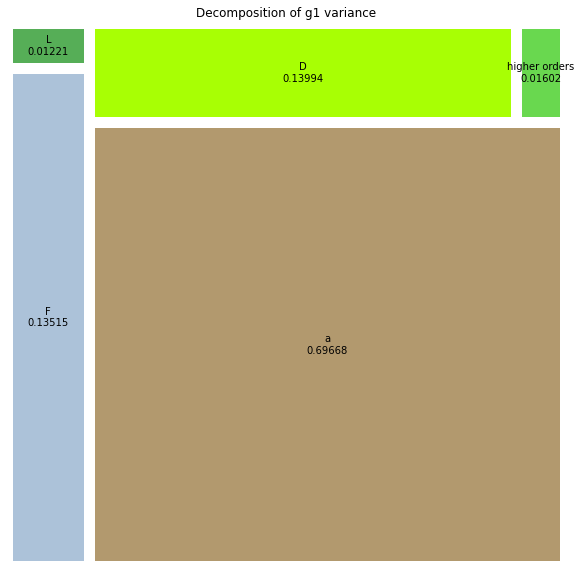

In [29]:
results.plot_sobols_treemap('g1', figsize=(10, 10))
plt.axis('off');

Alternatively you can get the Sobol index values using the method call below.

In [30]:
results.sobols_first('g1')

{'F': array([0.13515478]),
 'L': array([0.01220653]),
 'a': array([0.69667914]),
 'D': array([0.13994264])}